**Code to analyze the noise model developed by Riccardo to understand the effect of 
beta and alpha parameters on the scoring function for the trifunctional crosslinker 
case**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the model parameters

num_particles = 1000


num_observed_xls = 100
num_observed_xls_true = 80
num_lysines = 50
num_lysine_pairs = 50*49 // 2 # nC2(num_lysines)
num_lysine_triplets = 50*49*48 // 6 # nC3(num_lysines)
num_xl_lysine_pairs = 0.1 * num_lysine_pairs
num_xl_lysine_triplets = 0.05 * num_lysine_triplets

# alpha = (num_observed_xls_true / num_observed_xls))
alpha = (num_observed_xls_true / num_observed_xls)
beta = (num_xl_lysine_triplets / num_lysine_triplets)

print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.8
Beta: 0.05


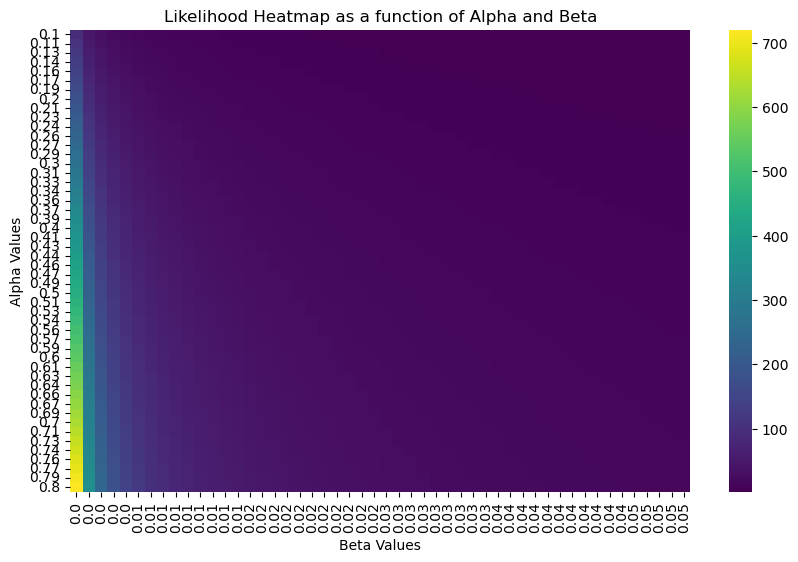

In [14]:
# Likelihood function
# (alpha/beta) * probability that the observed crosslink is true + (1-alpha/1-beta) *
# probability that the observed crosslink is false
# So the function to be plotted is fm = prob_true, then 1-fm = prob_false

def likelihood(fm, alpha, beta):
    prob_true = fm
    prob_false = 1 - fm
    likelihood_value = (alpha / beta) * prob_true + ((1 - alpha) / (1 - beta)) * prob_false
    return likelihood_value

# define fm value, for example, lets say the probability that a crosslink is true is high, 0.8
# Now plot the likelihood as a function of alpha and beta values 
fm = 0.9
alpha_values = np.linspace(0.1, 0.8, 50)
# since beta is a very small number for a trifunctional crosslinker, since 
# it is (no. of crosslinkable lysine triplets / total no. of lysine triplets)
# where the denominator is a very large number, we will limit beta values to a small range
beta_values = np.linspace(0.001, 0.05, 50)
likelihood_values = np.zeros((len(alpha_values), len(beta_values)))
for i, a in enumerate(alpha_values):
    for j, b in enumerate(beta_values):
        likelihood_values[i, j] = likelihood(fm, a, b)
# Plotting the likelihood heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(likelihood_values, xticklabels=np.round(beta_values, 2), yticklabels=np.round(alpha_values, 2), cmap="viridis")
plt.xlabel('Beta Values')
plt.ylabel('Alpha Values')
plt.title('Likelihood Heatmap as a function of Alpha and Beta')
plt.show()



System Setup:
  Particles: 50
  Total possible triplets: 19,600
  Observed XLs: 10 (8 TPs, 2 FPs)
  True alpha (precision): 0.800
  Estimated beta: 0.000026

Generated FM values: 10 crosslinks
  True positives (high fm): [0.79363503 0.93767858 0.88299849] ...
  False positives (low fm): [0.20027875 0.22701814] ...



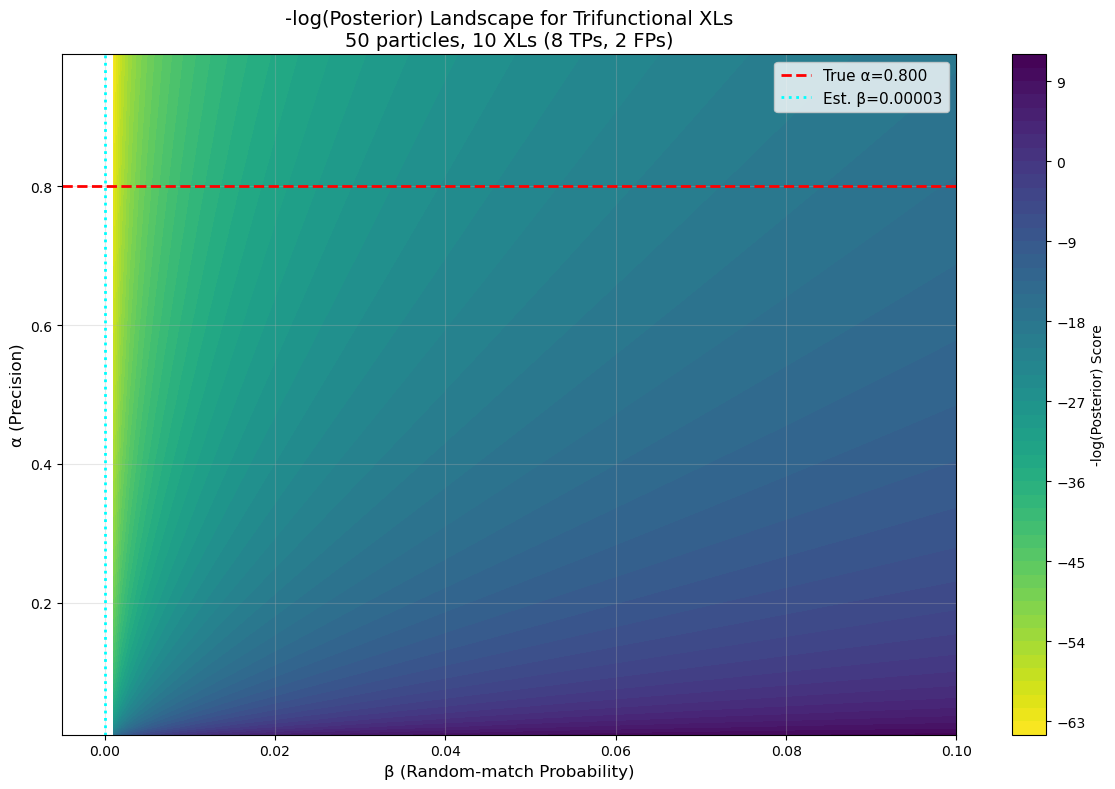

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_trifunctional_xl_noise_model(n_particles, n_crosslinks, n_false_positives):
    """
    Analyzes the noise model for trifunctional crosslinks using -log(posterior) scoring.
    
    Parameters:
    - n_particles: Number of particles in the system
    - n_crosslinks: Total number of observed crosslinks
    - n_false_positives: Number of false positives in the dataset
    
    Returns: Plots the -log(posterior) landscape showing how alpha and beta affect scoring
    """
    
    # --- 1. Calculate theoretical values ---
    n_true_positives = n_crosslinks - n_false_positives
    true_alpha = n_true_positives / n_crosslinks  # True precision
    
    # For trifunctional XLs: total possible triplets = nC3
    n_total_triplets = (n_particles * (n_particles - 1) * (n_particles - 2)) // 6
    
    # Estimate beta (assume ~5% of triplets are crosslinkable)
    true_beta = 0.05 * n_crosslinks / n_total_triplets
    
    print(f"System Setup:")
    print(f"  Particles: {n_particles}")
    print(f"  Total possible triplets: {n_total_triplets:,}")
    print(f"  Observed XLs: {n_crosslinks} ({n_true_positives} TPs, {n_false_positives} FPs)")
    print(f"  True alpha (precision): {true_alpha:.3f}")
    print(f"  Estimated beta: {true_beta:.6f}\n")
    
    # --- 2. Generate synthetic forward model probabilities ---
    # True positives get high fm values (0.7-0.95)
    # False positives get low fm values (0.05-0.3)
    np.random.seed(42)  # For reproducibility
    fm_true = np.random.uniform(0.7, 0.95, n_true_positives)
    fm_false = np.random.uniform(0.05, 0.3, n_false_positives)
    fm_values = np.concatenate([fm_true, fm_false])
    
    print(f"Generated FM values: {len(fm_values)} crosslinks")
    print(f"  True positives (high fm): {fm_true[:3]} ...")
    print(f"  False positives (low fm): {fm_false[:min(3, len(fm_false))]} ...\n")
    
    # --- 3. Define scoring function (negative log-posterior) ---
    def neg_log_posterior(fm_array, alpha, beta):
        """Calculate -log(posterior) for all crosslinks (lower is better)"""
        beta = max(beta, 1e-9)  # Prevent division by zero
        
        # Likelihood per crosslink: weighted sum of true and false match probabilities
        lik = (alpha / beta) * fm_array + ((1 - alpha) / (1 - beta)) * (1 - fm_array)
        
        # Return NEGATIVE log-likelihood (this is what we minimize in MCMC)
        return -np.sum(np.log(lik + 1e-300))
    
    # --- 4. Create parameter grid and compute score landscape ---
    alpha_grid = np.linspace(0.01, 0.99, 100)
    beta_grid = np.linspace(0.001, max(0.1, true_beta * 10), 100)
    
    # Compute -log(posterior) for all (alpha, beta) combinations
    score_surface = np.array([[neg_log_posterior(fm_values, a, b) 
                              for b in beta_grid] 
                             for a in alpha_grid])
    
    # --- 5. Plot the results ---
    plt.figure(figsize=(12, 8))
    
    # Contour plot of score landscape
    contour = plt.contourf(beta_grid, alpha_grid, score_surface, 
                          levels=50, cmap="viridis_r")  # _r reverses colormap (lower=better=darker)
    plt.colorbar(contour, label='-log(Posterior) Score')
    
    # Mark the true alpha (ground truth)
    plt.axhline(y=true_alpha, color='red', linestyle='--', linewidth=2,
               label=f'True α={true_alpha:.3f}')
    
    # Mark the estimated beta
    plt.axvline(x=true_beta, color='cyan', linestyle=':', linewidth=2,
               label=f'Est. β={true_beta:.5f}')
    
    plt.xlabel('β (Random-match Probability)', fontsize=12)
    plt.ylabel('α (Precision)', fontsize=12)
    plt.title(f'-log(Posterior) Landscape for Trifunctional XLs\n'
             f'{n_particles} particles, {n_crosslinks} XLs '
             f'({n_true_positives} TPs, {n_false_positives} FPs)', 
             fontsize=14)
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Example Usage ---

# Example 1: Small system (toy example)
analyze_trifunctional_xl_noise_model(
    n_particles=50,
    n_crosslinks=10,
    n_false_positives=2
)

# Example 2: Larger system (more realistic)
# analyze_trifunctional_xl_noise_model(
#     n_particles=100,
#     n_crosslinks=30,
#     n_false_positives=5
# )

In [4]:
import pymc as pm
import numpy as np
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

# ----------------------------------------------------------------------
# Part 1: System Representation & Synthetic Data Generation
# ----------------------------------------------------------------------

# --- Ground Truth Parameters (THE "ANSWER KEY") ---
N_PARTICLES = 1000
N_TOTAL_CROSSLINKS = 200
TRUE_FP_RATE = 0.30  # 30% of our crosslinks will be false positives
TRUE_OVERLENGTH_RATE = 0.20  # 20% of *true* crosslinks will be "over-length"
TRUE_SIGMA = 10.0  # The "fuzziness" (std dev) of over-length links (in Å)
# We will now calculate the TRUE_BETA empirically
L_TRI = 30.0  # The "true" max length (in Å) for all 3 arms of the linker

# --- Calculate data composition ---
N_FP = int(N_TOTAL_CROSSLINKS * TRUE_FP_RATE)
N_TP = N_TOTAL_CROSSLINKS - N_FP
N_TP_OVERLENGTH = int(N_TP * TRUE_OVERLENGTH_RATE)
N_TP_GOOD = N_TP - N_TP_OVERLENGTH

print(f"Generating synthetic data:")
print(f"  {N_TOTAL_CROSSLINKS} total crosslinks")
print(f"    - {N_FP} False Positives (FPs)")
print(f"    - {N_TP} True Positives (TPs), which are:")
print(f"        - {N_TP_GOOD} 'Good' TPs")
print(f"        - {N_TP_OVERLENGTH} 'Over-length' TPs")

# --- 1a. System Representation ---
particles_xyz = np.random.rand(N_PARTICLES, 3) * 100.0

def get_triplet_distances(p_idx, particles):
    """Helper function to get all 3 pairwise distances of a triplet."""
    p_a = particles[p_idx[0]]
    p_b = particles[p_idx[1]]
    p_c = particles[p_idx[2]]
    d_ab = np.linalg.norm(p_a - p_b)
    d_ac = np.linalg.norm(p_a - p_c)
    d_bc = np.linalg.norm(p_b - p_c)
    return d_ab, d_ac, d_bc

# --- 1b. Create Synthetic Data ---
# (This part is identical to before)
observed_distances_ab = []
observed_distances_ac = []
observed_distances_bc = []
observed_id_scores = []
data_types = []

for _ in range(N_TP_GOOD):
    while True:
        p_idx = np.random.choice(N_PARTICLES, 3, replace=False)
        d_ab, d_ac, d_bc = get_triplet_distances(p_idx, particles_xyz)
        if d_ab < L_TRI and d_ac < L_TRI and d_bc < L_TRI:
            observed_distances_ab.append(d_ab)
            observed_distances_ac.append(d_ac)
            observed_distances_bc.append(d_bc)
            observed_id_scores.append(np.clip(np.random.normal(0.85, 0.1), 0, 1))
            data_types.append("TP_Good")
            break

for _ in range(N_TP_OVERLENGTH):
    while True:
        p_idx = np.random.choice(N_PARTICLES, 3, replace=False)
        d_ab, d_ac, d_bc = get_triplet_distances(p_idx, particles_xyz)
        if d_ab < L_TRI and d_ac < L_TRI and d_bc < L_TRI:
            d_ab_corrupt = d_ab + np.abs(np.random.normal(0, TRUE_SIGMA))
            observed_distances_ab.append(d_ab_corrupt)
            observed_distances_ac.append(d_ac)
            observed_distances_bc.append(d_bc)
            observed_id_scores.append(np.clip(np.random.normal(0.80, 0.1), 0, 1))
            data_types.append("TP_Overlength")
            break

for _ in range(N_FP):
    p_idx = np.random.choice(N_PARTICLES, 3, replace=False)
    d_ab, d_ac, d_bc = get_triplet_distances(p_idx, particles_xyz)
    observed_distances_ab.append(d_ab)
    observed_distances_ac.append(d_ac)
    observed_distances_bc.append(d_bc)
    observed_id_scores.append(np.clip(np.random.normal(0.2, 0.1), 0, 1))
    data_types.append("FP")

d_ab_obs = np.array(observed_distances_ab)
d_ac_obs = np.array(observed_distances_ac)
d_bc_obs = np.array(observed_distances_bc)
id_scores_obs = np.array(observed_id_scores)
print("Synthetic data generation complete.")

# --- 1c. **NEW STEP**: Empirically Calculate True Beta ---
print("Empirically calculating true beta (random-match probability)...")
N_TEST_TRIPLETS = 100_000
satisfied_count = 0
for _ in range(N_TEST_TRIPLETS):
    p_idx = np.random.choice(N_PARTICLES, 3, replace=False)
    d_ab, d_ac, d_bc = get_triplet_distances(p_idx, particles_xyz)
    if d_ab < L_TRI and d_ac < L_TRI and d_bc < L_TRI:
        satisfied_count += 1

true_beta_empirical = satisfied_count / N_TEST_TRIPLETS
print(f"  Empirical Beta = {true_beta_empirical:.4f}")

# ----------------------------------------------------------------------
# Part 2: Model Definition (Scoring)
# ----------------------------------------------------------------------

with pm.Model() as toy_model:
    # --- 2a. Definition of Nuisance Parameters (Priors) ---
    
    # σ (Sigma): Structural "fuzziness" or uncertainty.
    # (True value = 10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)

    # β (Beta): **FIXED VALUE**
    # We are now *telling* the model the true random-match probability.
    beta = true_beta_empirical

    # --- 2b. Isotonic Regression (as a Differentiable Logistic Model) ---
    logistic_intercept = pm.Normal("logistic_intercept", mu=-3.0, sigma=1.0)
    logistic_slope = pm.HalfNormal("logistic_slope", sigma=2.0)

    calibrated_alpha = pm.math.sigmoid(
        logistic_intercept + logistic_slope * id_scores_obs
    )
    pm.Deterministic("calibrated_alpha", calibrated_alpha)

    # --- 2c. The Likelihood Function ---
    # P(Data | State) = P(TP) * P(Data | TP) + P(FP) * P(Data | FP)

    p_satisfied_fp = beta  # Use our fixed value

    # P(Data | TP) = The "Forward Model" (fm)
    # This is identical to before
    p_satisfied_ab_tp = pm.math.invlogit((L_TRI - d_ab_obs) / sigma)
    p_satisfied_ac_tp = pm.math.invlogit((L_TRI - d_ac_obs) / sigma)
    p_satisfied_bc_tp = pm.math.invlogit((L_TRI - d_bc_obs) / sigma)
    
    p_satisfied_tp = (
        p_satisfied_ab_tp * p_satisfied_ac_tp * p_satisfied_bc_tp
    )

    # --- The Final Combined Likelihood ---
    likelihood_per_xl = (
        calibrated_alpha * p_satisfied_tp +
        (1.0 - calibrated_alpha) * p_satisfied_fp
    )

    # --- The "Observation" ---
    obs = pm.Bernoulli(
        "obs",
        p=likelihood_per_xl,
        observed=np.ones(N_TOTAL_CROSSLINKS)
    )

print("Model definition complete.")

# ----------------------------------------------------------------------
# Part 3: Sampling (MCMC)
# ----------------------------------------------------------------------

print("Starting MCMC sampling...")
with toy_model:
    # Increase target_accept to 0.95 to help with divergences
    idata = pm.sample(
        2000, 
        tune=1500, 
        cores=4, 
        target_accept=0.95, 
        init="adapt_diag"
    )

print("Sampling complete.")

# ----------------------------------------------------------------------
# Part 4: Analysis
# ----------------------------------------------------------------------

print("Analyzing results...")

# --- 4a. Check Parameter Recovery ---
# 'beta' is no longer in the summary, as it wasn't sampled
summary = az.summary(
    idata, var_names=["sigma", "logistic_slope", "logistic_intercept"]
)
print(summary)

print("\n--- Ground Truth vs. Inferred ---")
print(f"sigma: True={TRUE_SIGMA:.2f}, Inferred={summary.loc['sigma', 'mean']:.2f}")

az.plot_trace(idata, var_names=["sigma", "logistic_slope"])
plt.suptitle("Parameter Trace Plots (Check for Convergence)")
plt.tight_layout()
plt.show()

# --- 4b. The "Isotonic Regression" Plot ---
mean_calibrated_alpha = idata.posterior["calibrated_alpha"].mean(
    dim=("chain", "draw")
)
color_map = {"TP_Good": "green", "TP_Overlength": "blue", "FP": "red"}
colors = [color_map[dt] for dt in data_types]

plt.figure(figsize=(10, 6))
plt.scatter(
    id_scores_obs,
    mean_calibrated_alpha,
    c=colors,
    alpha=0.7,
    label="Inferred Precision (per XL)"
)
plt.axvline(0.5, color='gray', linestyle='--', label='Approx. TP/FP cutoff')
plt.axhline(1.0 - TRUE_FP_RATE, color='black', linestyle=':', label=f'True Avg. Precision ({1.0 - TRUE_FP_RATE:.2f})')

plt.title("Model Validation: Calibrated Precision vs. ID Score")
plt.xlabel("Synthetic ID Score (Input)")
plt.ylabel("Inferred Calibrated Precision (α)")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', mfc='green', label='TP (Good)'),
    plt.Line2D([0], [0], marker='o', color='w', mfc='blue', label='TP (Over-length)'),
    plt.Line2D([0], [0], marker='o', color='w', mfc='red', label='FP (Noise)')
])
plt.show()

Running on PyMC v5.18.0
Generating synthetic data:
  200 total crosslinks
    - 60 False Positives (FPs)
    - 140 True Positives (TPs), which are:
        - 112 'Good' TPs
        - 28 'Over-length' TPs
Synthetic data generation complete.
Empirically calculating true beta (random-match probability)...
  Empirical Beta = 0.0034
Model definition complete.
Starting MCMC sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, logistic_intercept, logistic_slope]


Output()

ConnectionResetError: [Errno 104] Connection reset by peer

Running on PyMC v5.18.0
TRIFUNCTIONAL CROSSLINKING SYSTEM
Physical System:
  - 1000 particles in 100.0³ Å³ box
  - Crosslinker max length: 30.0 Å

Data Composition:
  - Total crosslinks: 300
  - True Positives: 210 (70%)
  - False Positives: 90 (30%)

Generating synthetic data...
  Creating 210 true positives...
    Generated 210 TPs in 63820 attempts
  Creating 90 false positives...
  Data generation complete!

Calculating empirical beta (random match probability)...
  This is P(random triplet satisfies all constraints)
  beta = 0.00345 (345/100000 satisfied)
  Theoretical estimate: beta ≈ 0.02700


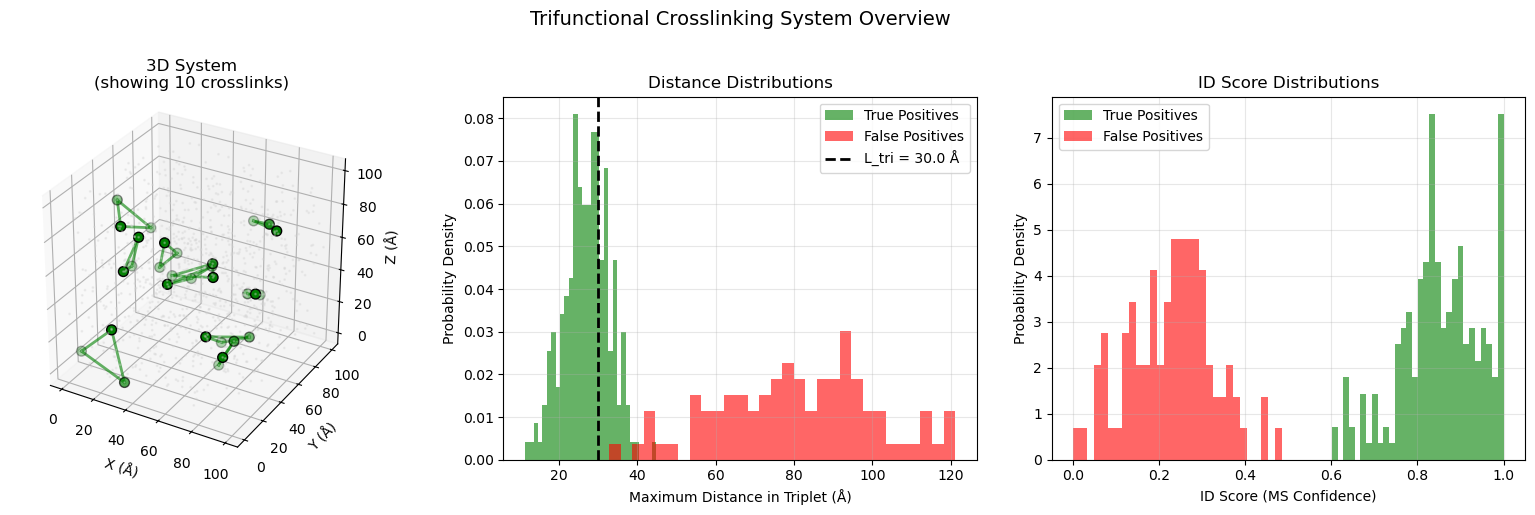


BAYESIAN INFERENCE MODEL
Model structure:
  Free parameters: sigma, intercept, slope
  Fixed parameter: beta = 0.00345
  Observations: 300 crosslinks

Running MCMC sampling...
  This may take a few minutes...


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Output()

ConnectionResetError: [Errno 104] Connection reset by peer

In [8]:
"""
Trifunctional Crosslinking Mass Spectrometry Model
===================================================
A Bayesian inference model for tri-functional crosslinking experiments.

Physical System:
- N particles randomly distributed in 3D space
- Each crosslink connects 3 particles (triplet)
- Constraint: all pairwise distances must be < L_tri (linker length)

Model Components:
1. True Positives (TP): Real crosslinks satisfying geometric constraints
2. False Positives (FP): Random noise from mass spec misidentification
3. ID Score: Mass spectrometry confidence score (higher = more likely TP)

Inference Goal:
- Infer σ: structural flexibility/uncertainty in distance measurements
- Calibrate ID scores to true positive probability (isotonic-like regression)
"""

import pymc as pm
import numpy as np
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

print(f"Running on PyMC v{pm.__version__}")
np.random.seed(42)  # For reproducibility

# ==============================================================================
# PART 1: PHYSICAL SYSTEM PARAMETERS
# ==============================================================================

# System size and geometry
N_PARTICLES = 1000          # Number of particles in 3D space
BOX_SIZE = 100.0            # Size of cubic simulation box (Å)
L_TRI = 30.0               # Maximum crosslinker arm length (Å)

# Data composition
N_TOTAL_CROSSLINKS = 300    # Total observed crosslinks
TRUE_FP_RATE = 0.30        # Fraction that are false positives
TRUE_SIGMA = 5.0           # Distance measurement uncertainty (Å)

# Calculate data splits
N_FP = int(N_TOTAL_CROSSLINKS * TRUE_FP_RATE)
N_TP = N_TOTAL_CROSSLINKS - N_FP

print("="*70)
print("TRIFUNCTIONAL CROSSLINKING SYSTEM")
print("="*70)
print(f"Physical System:")
print(f"  - {N_PARTICLES} particles in {BOX_SIZE}³ Å³ box")
print(f"  - Crosslinker max length: {L_TRI} Å")
print(f"\nData Composition:")
print(f"  - Total crosslinks: {N_TOTAL_CROSSLINKS}")
print(f"  - True Positives: {N_TP} ({100*(1-TRUE_FP_RATE):.0f}%)")
print(f"  - False Positives: {N_FP} ({100*TRUE_FP_RATE:.0f}%)")

# ==============================================================================
# PART 2: GENERATE PARTICLE SYSTEM AND SYNTHETIC DATA
# ==============================================================================

# Generate random particle positions in 3D space
particles_xyz = np.random.rand(N_PARTICLES, 3) * BOX_SIZE

def calculate_triplet_distances(indices, particles):
    """
    Calculate all three pairwise distances for a particle triplet.
    
    For a trifunctional crosslinker connecting particles A, B, C:
    - d_AB: distance between particles A and B
    - d_AC: distance between particles A and C  
    - d_BC: distance between particles B and C
    
    All three must be < L_TRI for a valid crosslink.
    """
    pA, pB, pC = particles[indices[0]], particles[indices[1]], particles[indices[2]]
    d_AB = np.linalg.norm(pA - pB)
    d_AC = np.linalg.norm(pA - pC)
    d_BC = np.linalg.norm(pB - pC)
    return d_AB, d_AC, d_BC

def check_constraint_satisfaction(d_AB, d_AC, d_BC, L_max):
    """Check if all three distances satisfy the crosslinker constraint."""
    return (d_AB < L_max) and (d_AC < L_max) and (d_BC < L_max)

# Storage for synthetic data
observed_distances = {'AB': [], 'AC': [], 'BC': []}
observed_id_scores = []
true_labels = []  # 1 for TP, 0 for FP
particle_indices = []  # Store which particles are involved

print("\nGenerating synthetic data...")

# Generate True Positives (real crosslinks)
print(f"  Creating {N_TP} true positives...")
tp_count = 0
attempts = 0
max_attempts = N_TP * 1000  # Prevent infinite loop

while tp_count < N_TP and attempts < max_attempts:
    attempts += 1
    # Select random triplet
    idx = np.random.choice(N_PARTICLES, 3, replace=False)
    d_AB, d_AC, d_BC = calculate_triplet_distances(idx, particles_xyz)
    
    # Check if satisfies geometric constraint
    if check_constraint_satisfaction(d_AB, d_AC, d_BC, L_TRI):
        # Add noise to distances (measurement uncertainty)
        d_AB_obs = d_AB + np.random.normal(0, TRUE_SIGMA)
        d_AC_obs = d_AC + np.random.normal(0, TRUE_SIGMA)
        d_BC_obs = d_BC + np.random.normal(0, TRUE_SIGMA)
        
        observed_distances['AB'].append(d_AB_obs)
        observed_distances['AC'].append(d_AC_obs)
        observed_distances['BC'].append(d_BC_obs)
        
        # TPs have high ID scores (mass spec confidence)
        id_score = np.clip(np.random.normal(0.85, 0.1), 0, 1)
        observed_id_scores.append(id_score)
        true_labels.append(1)
        particle_indices.append(idx)
        tp_count += 1

print(f"    Generated {tp_count} TPs in {attempts} attempts")

# Generate False Positives (random misidentifications)
print(f"  Creating {N_FP} false positives...")
for _ in range(N_FP):
    # FPs are completely random triplets (no constraint needed)
    idx = np.random.choice(N_PARTICLES, 3, replace=False)
    d_AB, d_AC, d_BC = calculate_triplet_distances(idx, particles_xyz)
    
    observed_distances['AB'].append(d_AB)
    observed_distances['AC'].append(d_AC)
    observed_distances['BC'].append(d_BC)
    
    # FPs have low ID scores
    id_score = np.clip(np.random.normal(0.25, 0.1), 0, 1)
    observed_id_scores.append(id_score)
    true_labels.append(0)
    particle_indices.append(idx)

# Convert to arrays
d_AB_obs = np.array(observed_distances['AB'])
d_AC_obs = np.array(observed_distances['AC'])
d_BC_obs = np.array(observed_distances['BC'])
id_scores_obs = np.array(observed_id_scores)
true_labels = np.array(true_labels)

print("  Data generation complete!")

# ==============================================================================
# PART 3: CALCULATE EMPIRICAL BETA (RANDOM MATCH PROBABILITY)
# ==============================================================================

print("\nCalculating empirical beta (random match probability)...")
print("  This is P(random triplet satisfies all constraints)")

N_MONTE_CARLO = 100_000
satisfied_count = 0

for _ in range(N_MONTE_CARLO):
    idx = np.random.choice(N_PARTICLES, 3, replace=False)
    d_AB, d_AC, d_BC = calculate_triplet_distances(idx, particles_xyz)
    if check_constraint_satisfaction(d_AB, d_AC, d_BC, L_TRI):
        satisfied_count += 1

beta_empirical = satisfied_count / N_MONTE_CARLO
print(f"  beta = {beta_empirical:.5f} ({satisfied_count}/{N_MONTE_CARLO} satisfied)")

# Theoretical estimate (for comparison)
# Assuming uniform distribution, P(d < L) ≈ (L/BOX_SIZE)³ for each distance
beta_theoretical = (L_TRI / BOX_SIZE) ** 3
print(f"  Theoretical estimate: beta ≈ {beta_theoretical:.5f}")

# ==============================================================================
# PART 4: VISUALIZE THE PHYSICAL SYSTEM
# ==============================================================================

def visualize_system():
    """Create visualization of the particle system and crosslinks."""
    fig = plt.figure(figsize=(16, 5))
    
    # --- Subplot 1: 3D Particle System ---
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Plot all particles as small dots
    ax1.scatter(particles_xyz[:, 0], particles_xyz[:, 1], particles_xyz[:, 2],
               c='lightgray', s=1, alpha=0.3)
    
    # Highlight first few crosslinks
    n_show = min(10, N_TP)
    for i in range(n_show):
        idx = particle_indices[i]
        triplet = particles_xyz[idx]
        
        # Draw triangle connecting the three particles
        for j in range(3):
            for k in range(j+1, 3):
                ax1.plot([triplet[j, 0], triplet[k, 0]],
                        [triplet[j, 1], triplet[k, 1]],
                        [triplet[j, 2], triplet[k, 2]],
                        'g-' if true_labels[i] == 1 else 'r-',
                        alpha=0.6, linewidth=2)
        
        # Mark the three particles
        ax1.scatter(triplet[:, 0], triplet[:, 1], triplet[:, 2],
                   c='green' if true_labels[i] == 1 else 'red',
                   s=50, edgecolors='black', linewidth=1)
    
    ax1.set_xlabel('X (Å)')
    ax1.set_ylabel('Y (Å)')
    ax1.set_zlabel('Z (Å)')
    ax1.set_title(f'3D System\n(showing {n_show} crosslinks)')
    ax1.set_box_aspect([1,1,1])
    
    # --- Subplot 2: Distance Distributions ---
    ax2 = fig.add_subplot(132)
    
    # Separate TP and FP distances
    tp_mask = true_labels == 1
    fp_mask = ~tp_mask
    
    # Plot max distance for each crosslink
    d_max_obs = np.maximum(d_AB_obs, np.maximum(d_AC_obs, d_BC_obs))
    
    ax2.hist(d_max_obs[tp_mask], bins=30, alpha=0.6, color='green', 
            label='True Positives', density=True)
    ax2.hist(d_max_obs[fp_mask], bins=30, alpha=0.6, color='red',
            label='False Positives', density=True)
    ax2.axvline(L_TRI, color='black', linestyle='--', linewidth=2,
               label=f'L_tri = {L_TRI} Å')
    
    ax2.set_xlabel('Maximum Distance in Triplet (Å)')
    ax2.set_ylabel('Probability Density')
    ax2.set_title('Distance Distributions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- Subplot 3: ID Score Distributions ---
    ax3 = fig.add_subplot(133)
    
    ax3.hist(id_scores_obs[tp_mask], bins=30, alpha=0.6, color='green',
            label='True Positives', density=True)
    ax3.hist(id_scores_obs[fp_mask], bins=30, alpha=0.6, color='red',
            label='False Positives', density=True)
    
    ax3.set_xlabel('ID Score (MS Confidence)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('ID Score Distributions')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle('Trifunctional Crosslinking System Overview', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'crosslinking_system.pdf'), dpi=300, bbox_inches='tight')
    return fig

# Create and show visualization
fig_system = visualize_system()
plt.show()

# ==============================================================================
# PART 5: BAYESIAN MODEL DEFINITION
# ==============================================================================

print("\n" + "="*70)
print("BAYESIAN INFERENCE MODEL")
print("="*70)

with pm.Model() as crosslinking_model:
    
    # --- Prior Distributions ---
    
    # σ: Distance measurement uncertainty (structural flexibility)
    # Prior: weakly informative, expecting ~5Å uncertainty
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    
    # β: Random match probability (FIXED from empirical calculation)
    # This is not inferred but used as a known constant
    beta = beta_empirical
    
    # --- Isotonic-like Regression for ID Score Calibration ---
    # We use a smooth logistic function instead of true isotonic regression
    # This maps ID scores to precision (probability of being TP)
    
    # Logistic regression parameters
    intercept = pm.Normal("intercept", mu=-2.0, sigma=1.0)
    slope = pm.HalfNormal("slope", sigma=5.0)
    
    # Calibrated precision for each crosslink
    # α(ID) = sigmoid(intercept + slope * ID_score)
    calibrated_alpha = pm.math.sigmoid(intercept + slope * id_scores_obs)
    pm.Deterministic("calibrated_alpha", calibrated_alpha)
    
    # --- Forward Model: P(distances | crosslink type) ---
    
    # For False Positives: uniform random matches
    p_satisfied_fp = beta
    
    # For True Positives: distances should satisfy constraints
    # Using soft constraint via sigmoid function: P(d < L) = sigmoid((L - d) / σ)
    p_AB_satisfied = pm.math.sigmoid((L_TRI - d_AB_obs) / sigma)
    p_AC_satisfied = pm.math.sigmoid((L_TRI - d_AC_obs) / sigma)
    p_BC_satisfied = pm.math.sigmoid((L_TRI - d_BC_obs) / sigma)
    
    # All three constraints must be satisfied (independence assumption)
    p_satisfied_tp = p_AB_satisfied * p_AC_satisfied * p_BC_satisfied
    
    # --- Mixture Model Likelihood ---
    # P(observed | parameters) = α * P(observed | TP) + (1-α) * P(observed | FP)
    likelihood_per_crosslink = (
        calibrated_alpha * p_satisfied_tp + 
        (1 - calibrated_alpha) * p_satisfied_fp
    )
    
    # --- Observation Model ---
    # We observe that all crosslinks "exist" (binary observation = 1)
    obs = pm.Bernoulli(
        "obs",
        p=likelihood_per_crosslink,
        observed=np.ones(N_TOTAL_CROSSLINKS)
    )

print("Model structure:")
print(f"  Free parameters: sigma, intercept, slope")
print(f"  Fixed parameter: beta = {beta_empirical:.5f}")
print(f"  Observations: {N_TOTAL_CROSSLINKS} crosslinks")

# ==============================================================================
# PART 6: MCMC SAMPLING
# ==============================================================================

print("\nRunning MCMC sampling...")
print("  This may take a few minutes...")

with crosslinking_model:
    # Sample from posterior
    trace = pm.sample(
        draws=3000,
        tune=2000,
        cores=4,
        target_accept=0.95,  # High to avoid divergences
        init="adapt_diag",
        return_inferencedata=True
    )

print("Sampling complete!")

# ==============================================================================
# PART 7: RESULTS ANALYSIS
# ==============================================================================

print("\n" + "="*70)
print("INFERENCE RESULTS")
print("="*70)

# Parameter summary
summary = az.summary(trace, var_names=["sigma", "intercept", "slope"])
print("\nParameter Summary:")
print(summary)

print("\nGround Truth vs Inferred:")
print(f"  σ: True = {TRUE_SIGMA:.2f} Å, Inferred = {summary.loc['sigma', 'mean']:.2f} ± {summary.loc['sigma', 'sd']:.2f} Å")

# Convergence diagnostics
print(f"\nConvergence Diagnostics:")
print(f"  Max R-hat: {summary['r_hat'].max():.3f} (should be < 1.01)")
print(f"  Min ESS: {summary[['ess_bulk', 'ess_tail']].min().min():.0f} (should be > 400)")

# ==============================================================================
# PART 8: VISUALIZATION OF RESULTS
# ==============================================================================

def plot_results():
    """Create comprehensive results visualization."""
    fig = plt.figure(figsize=(15, 10))
    
    # --- Trace Plots ---
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(trace.posterior["sigma"].values.flatten(), alpha=0.7, linewidth=0.5)
    ax1.axhline(TRUE_SIGMA, color='red', linestyle='--', label=f'True = {TRUE_SIGMA}')
    ax1.set_title('sigma Trace')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel(r'sigma ({\AA})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(trace.posterior["intercept"].values.flatten(), alpha=0.7, linewidth=0.5)
    ax2.set_title('Intercept Trace')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Intercept')
    ax2.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(trace.posterior["slope"].values.flatten(), alpha=0.7, linewidth=0.5)
    ax3.set_title('Slope Trace')
    ax3.set_xlabel('Sample')
    ax3.set_ylabel('Slope')
    ax3.grid(True, alpha=0.3)
    
    # --- Posterior Distributions ---
    ax4 = plt.subplot(3, 3, 4)
    ax4.hist(trace.posterior["sigma"].values.flatten(), bins=50, density=True, alpha=0.7)
    ax4.axvline(TRUE_SIGMA, color='red', linestyle='--', label=f'True = {TRUE_SIGMA}')
    ax4.set_title('σ Posterior')
    ax4.set_xlabel('σ (Å)')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(trace.posterior["intercept"].values.flatten(), bins=50, density=True, alpha=0.7)
    ax5.set_title('Intercept Posterior')
    ax5.set_xlabel('Intercept')
    ax5.set_ylabel('Density')
    ax5.grid(True, alpha=0.3)
    
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(trace.posterior["slope"].values.flatten(), bins=50, density=True, alpha=0.7)
    ax6.set_title('Slope Posterior')
    ax6.set_xlabel('Slope')
    ax6.set_ylabel('Density')
    ax6.grid(True, alpha=0.3)
    
    # --- Calibration Curve (Isotonic-like) ---
    ax7 = plt.subplot(3, 3, (7, 9))
    
    # Get mean calibrated alpha
    mean_alpha = trace.posterior["calibrated_alpha"].mean(dim=("chain", "draw"))
    
    # Color points by true label
    colors = ['green' if label == 1 else 'red' for label in true_labels]
    
    # Main scatter plot
    scatter = ax7.scatter(id_scores_obs, mean_alpha, c=colors, alpha=0.6, s=30)
    
    # Add smooth calibration curve
    id_grid = np.linspace(0, 1, 100)
    mean_intercept = trace.posterior["intercept"].mean().values
    mean_slope = trace.posterior["slope"].mean().values
    smooth_curve = 1 / (1 + np.exp(-(mean_intercept + mean_slope * id_grid)))
    ax7.plot(id_grid, smooth_curve, 'b-', linewidth=2, label='Calibration Curve')
    
    # Reference lines
    ax7.axhline(1 - TRUE_FP_RATE, color='black', linestyle=':', 
               label=f'Target Precision = {1-TRUE_FP_RATE:.2f}')
    ax7.axvline(0.5, color='gray', linestyle='--', alpha=0.5, 
               label='ID Score = 0.5')
    
    ax7.set_xlabel('ID Score (MS Confidence)')
    ax7.set_ylabel('Calibrated Precision α')
    ax7.set_title('ID Score Calibration (Smooth Isotonic-like Regression)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim([0, 1])
    ax7.set_ylim([0, 1])
    
    # Add legend for colors
    tp_patch = mpatches.Patch(color='green', label='True Positive')
    fp_patch = mpatches.Patch(color='red', label='False Positive')
    ax7.legend(handles=[tp_patch, fp_patch, ax7.get_lines()[0]], 
              loc='lower right')
    
    plt.suptitle('Bayesian Inference Results', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

# Create and show results
fig_results = plot_results()
plt.show()

# ==============================================================================
# PART 9: PERFORMANCE EVALUATION
# ==============================================================================

print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)

# Calculate predicted labels using calibrated scores
mean_alpha = trace.posterior["calibrated_alpha"].mean(dim=("chain", "draw")).values
predicted_labels = (mean_alpha > 0.5).astype(int)

# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nClassification Performance:")
print(f"  Accuracy:  {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1 Score:  {f1:.3f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(f"\nConfusion Matrix:")
print(f"  TP: {cm[1,1]:3d}  FP: {cm[0,1]:3d}")
print(f"  FN: {cm[1,0]:3d}  TN: {cm[0,0]:3d}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

# create a folder for output files
import os
output_dir = './output_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figures
fig_system.savefig(os.path.join(output_dir, 'crosslinking_system.png'), dpi=150, bbox_inches='tight')
fig_results.savefig(os.path.join(output_dir, 'crosslinking_results.png'), dpi=150, bbox_inches='tight')
print("\nFigures saved to outputs directory.")